Chapter 1 - Multinomial BNs - Probabilistic Reasoning - approximate inference

Train Survey

- Age - young, adult, old <br>
- Sex - male, female <br>
- Education - high (high-school), university degree <br>
- Occupation - emp (employee), self-employed (self) <br>
- Residence - city  size: small, big <br>
- Transportation - car, train, other

In [ ]:
install.packages(
  "bnlearn",
  repos = "https://cloud.r-project.org",   # CRAN mirror
  dependencies = TRUE                      # pulls in igraph, gRain, etc.
)

In [ ]:
install.packages(
  "gRain",
  repos = "https://cloud.r-project.org",   # CRAN mirror
  dependencies = TRUE                      # pulls in igraph, gRain, etc.
)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘cowplot’, ‘Deriv’, ‘doBy’, ‘litedown’, ‘gRim’, ‘markdown’, ‘microbenchmark’


Loading required package: gRbase


Attaching package: ‘gRbase’


The following objects are masked from ‘package:bnlearn’:

    ancestors, children, nodes, parents




In [93]:
library(bnlearn)
library(gRain)

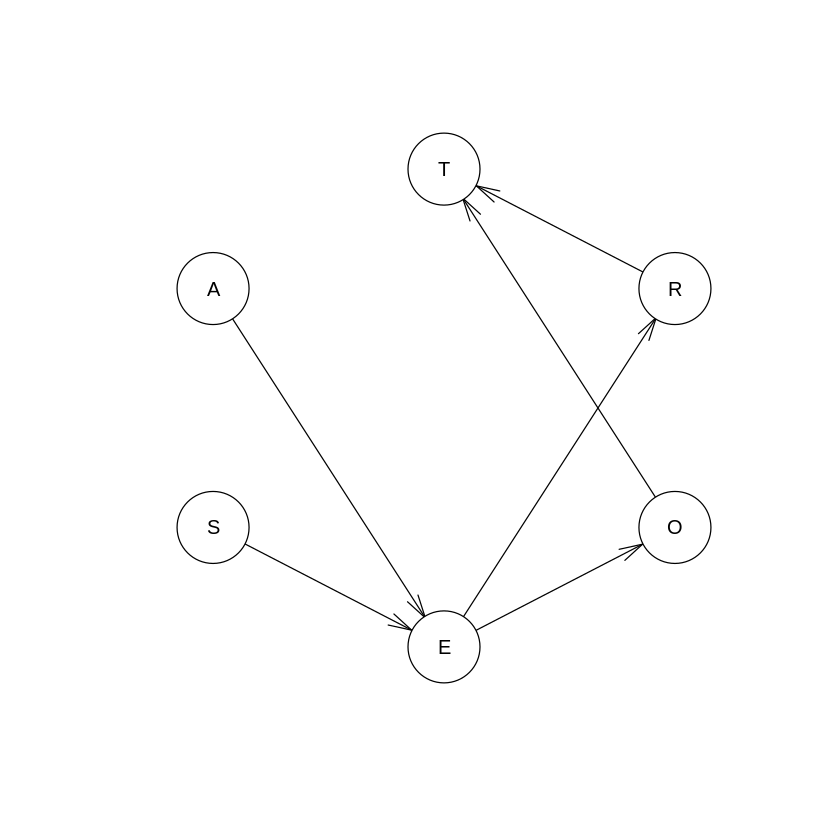

In [94]:
rm(list = ls())
setwd("/content")

# create an empty graph
dag <- empty.graph(nodes = c("A", "S", "E", "O", "R", "T"))

# Add in the edges
dag <- set.arc(dag, from = "A", to = "E") # age influences education
dag <- set.arc(dag, from = "S", to = "E") # sex influences education
dag <- set.arc(dag, from = "E", to = "O") # ....
dag <- set.arc(dag, from = "E", to = "R") # ....
dag <- set.arc(dag, from = "O", to = "T") # ....
dag <- set.arc(dag, from = "R", to = "T") # ....

plot(dag)

# Read in the data
survey <- read.table("survey.txt", header = TRUE, colClasses = "factor")

# define the states
A.lv <- c("young", "adult", "old")
S.lv <- c("M", "F")
E.lv <- c("high", "uni")
O.lv <- c("emp", "self")
R.lv <- c("small", "big")
T.lv <- c("car", "train", "other")

# specify the CPT for every node ("Expert Defined")
A.prob <- array(c(0.30, 0.50, 0.20), dim = 3, dimnames = list(A = A.lv))

S.prob <- array(c(0.60, 0.4), dim = 2, dimnames = list(S=S.lv))

O.prob <- array(c(0.96, 0.04, 0.92, 0.08), dim = c(2,2),
                dimnames = list(O=O.lv, E=E.lv))

R.prob <- array(c(0.25, 0.75, 0.20, 0.80), dim = c(2,2),
               dimnames = list(R = R.lv, E = E.lv))

E.prob <- array(c(0.75, 0.25, 0.72, 0.28, 0.88, 0.12, 0.64,
                  0.36, 0.70, 0.30, 0.90, 0.10), dim = c(2,3,2), dimnames = list(E=E.lv, A = A.lv, S = S.lv))

T.prob <- array(c(0.48, 0.42, 0.10, 0.56, 0.36, 0.08, 0.58,
                 0.24, 0.18, 0.70, 0.21, 0.09), dim = c(3,2,2),
                dimnames = list(T=T.lv, O = O.lv, R = R.lv))

cpt <- list(A = A.prob, S = S.prob, E = E.prob, O = O.prob, R = R.prob,
           T = T.prob)
bn <- custom.fit(dag, dist = cpt)

[1] "bn.fit"      "bn.fit.dnet"

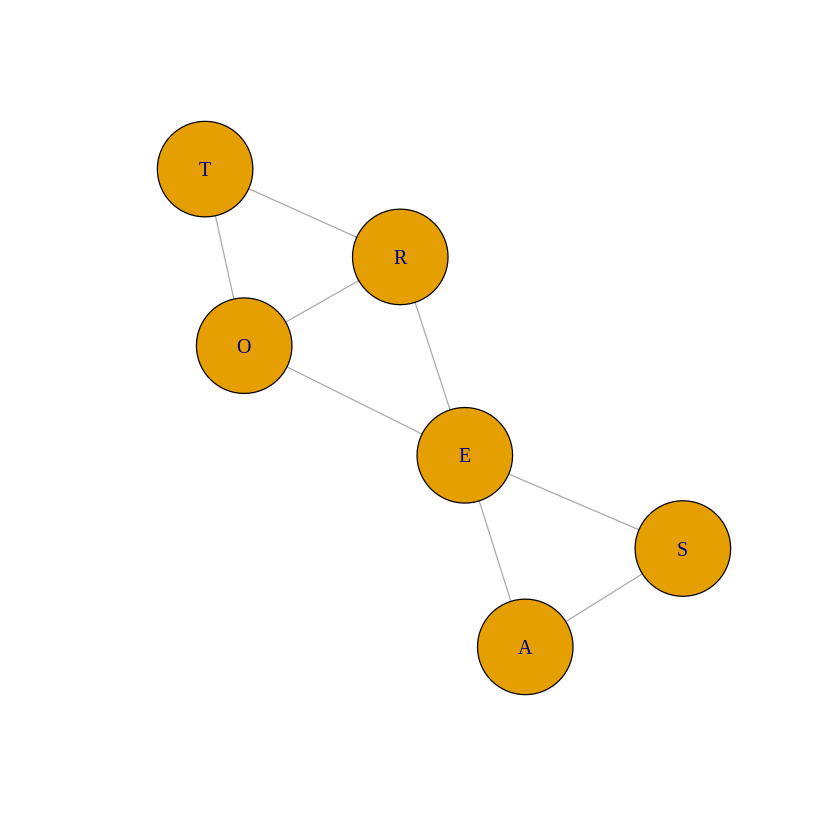

In [95]:
class(bn)
junction <- compile(as.grain(bn))
plot(junction)

In [96]:
# Exact inference
jedu <- setEvidence(junction, nodes = "E", states = "high")
SxT <- querygrain(jedu, nodes = c("S", "T"), type = "joint")
SxT

,car,train,other
M,0.3426644,0.1736599,0.09623271
F,0.2167356,0.1098401,0.06086729


In [97]:
# Approximate Inference - via Monte Carlo Simulation
# ?cpquery
my_query1 <- cpquery(bn, event = (S == "M") & (T == "car"), evidence = (E == "high"))
my_query1

[1] 0.3417344

In [98]:
# small sample size
my_query2 <- cpquery(bn, event = (S == "M") & (T == "car"), evidence = (E == "high"), n = 10)
my_query2

# large sample size
my_query3 <- cpquery(bn, event = (S == "M") & (T == "car"), evidence = (E == "high"), n = 10^6)
my_query3

[1] 0.2857143

[1] 0.3415959

In [99]:
# Approximate Inference - via Likelihood Weighting
my_query4 <- cpquery(bn, event = (S == "M") & (T == "car"), evidence = list(E = "high"), method = "lw")
my_query4

[1] 0.3375802

Lets look at a more complicated query that we wouldn't get with exact inference<br>
$\Pr(S=M, T= car \mid \{A=young, E = uni\} \cup \{A = adult\})$

In [100]:
cpquery(bn, event = (S == "M") & (T == "car"), evidence = ((A == "young") & (E == "uni")) | (A == "adult"), n = 100000)

[1] 0.3299373

In [101]:
# extract the monte carlo data ie random observations for the variables in "nodes" that match the evidence
SxT <- cpdist(bn, nodes = c("S", "T"), evidence = (E == "high"))
head(SxT)

,S,T
,<fct>,<fct>
1,M,other
2,M,other
3,F,car
4,M,train
5,F,train
6,F,car


In [102]:
dim(SxT)

[1] 3704    2

In [103]:
# lots of flexibility to do other things because now we have the data under fixed evidence
summ <- table(SxT)
prop.table(summ) # summary table of probability

   T
S          car      train      other
  M 0.35394168 0.17575594 0.08639309
  F 0.20626350 0.11366091 0.06398488